# Notebook to make Fig. 14

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json
import arviz as az

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

style.use('plotting.mplstyle')

import sys
sys.path.append('./../Code/PopulationInference')
from fig_helper_functions import *
from posterior_helper_functions import *
sys.path.append('./../Code/GeneratePopulations')
from helper_functions import *

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

In [3]:
# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)
chieff_grid =  np.linspace(-1,1,500)
chip_grid =  np.linspace(0,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

In [4]:
# Calculate true injected rates
# To do this we'll need to load in found injections
with open("../Data/PopulationInferenceInput/injectionDict.json","r") as jf:
    injectionDict = json.load(jf)

for key in injectionDict:
    injectionDict[key] = np.array(injectionDict[key])

# Read out injection parameters
injectionDict['nTrials'] = len(injectionDict['m1'])
a1_det = injectionDict['a1']
a2_det = injectionDict['a2']
cost1_det = injectionDict['cost1']
cost2_det = injectionDict['cost2']
m1_det = injectionDict['m1']
m2_det = injectionDict['m2']
z_det = injectionDict['z']
dVdz_det = injectionDict['dVdz']

# Compute true mass distribution
f_m1_true = p_astro_m1(m1_det,mCut=8.)
f_m1_ref = p_astro_m1(np.array([30.]),mCut=8.)

# True mass ratio distribution
bq_true = 0.96
p_m2_true = (1.+bq_true)*m2_det**bq_true/(m1_det**(1.+bq_true) - 8.**(1.+bq_true))

# True redshift distribution
kappa_true = 2.7
f_z_ref = (1.+0.2)**kappa_true
f_z_true = (1.+z_det)**(kappa_true-1)*dVdz_det

In [5]:
injected_rate_dict = {}
for key in kde_dict:
    
    p_a1_true = np.interp(a1_det,chi_grid,kde_dict[key]['chi'])
    p_a2_true = np.interp(a2_det,chi_grid,kde_dict[key]['chi'])
    p_cost1_true = np.interp(cost1_det,cost_grid,kde_dict[key]['cost'])
    p_cost2_true = np.interp(cost2_det,cost_grid,kde_dict[key]['cost'])
    
    dRdx_unnormed = (f_m1_true/f_m1_ref)*p_m2_true*p_a1_true*p_a2_true*p_cost1_true*p_cost2_true*(f_z_true/f_z_ref)
    mc_sum = np.sum(dRdx_unnormed/(injectionDict['p_draw_m1m2z']*injectionDict['p_draw_a1a2cost1cost2']))/injectionDict['nTrials']

    R_ref_true = 70./mc_sum
    injected_rate_dict[key] = R_ref_true

In [6]:
# For loading files
pops = ['1', '2', '3']
nevents = ['070', '300'] 

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        
        print(pop, nevent)
        
        numpyro_dir = "../Code/PopulationInference/numpyro/output/"
        name = numpyro_dir+"pop{0}_{1}_events_fitMasses.cdf".format(pop,nevent)
        
        data = az.from_netcdf(name)
        samps = data.posterior.stack(draws=("chain", "draw"))
            
        data_pop[nevent+' events'] = samps    
            
    data_dict['pop '+pop] = data_pop

1 070
1 300
2 070
2 300
3 070
3 300


In [7]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations and numbers of events
for pop in pops: 
    
    pop_key = 'pop '+pop
    traces_pop = {}

    print(pop_key)
    
    for nevent in nevents: 
                    
        # Fetch data
        nevent_key = nevent+' events'
        data = data_dict[pop_key][nevent_key]
        
        # Instantiate an array to hold a collection of traces
        nTraces = min(nTracesMax, len(data['mu_chi'].values))
        R_chi = np.zeros((nTraces,chi_grid.size))
        R_cost = np.zeros((nTraces,cost_grid.size))
        R_chieff = np.zeros((nTraces,chieff_grid.size))
        R_chip = np.zeros((nTraces,chip_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        random_indices = np.random.choice(np.arange(len(data['mu_chi'].values)), size=nTraces,replace=False)
        for i,ind in enumerate(random_indices):
            
            print(i, end='\r')

            z_ref = 0.2
            R_ref = np.array(data['R30'].values)[ind]
            kappa = np.array(data['kappa'].values)[ind]
            
            mu_chi = np.array(data['mu_chi'].values)[ind]
            sigma_chi = np.array(data['sig_chi'].values)[ind]
            mu1_cost = np.array(data['mu_cost_high'])[ind]
            sigma1_cost = np.array(data['sig_cost_high'])[ind]
            mu2_cost = np.array(data['mu_cost_low'])[ind]
            sigma2_cost = np.array(data['sig_cost_low'])[ind]
            MF_cost = np.array(data['f_big'])[ind]
            Bq = np.array(data['bq'])[ind]

            # calculate gaussian distribution for chi
            R_chi[i,:] = R_ref*calculate_Gaussian_1D(chi_grid, mu_chi, sigma_chi,0,1)**2

            # and gaussian distribution for cos(theta)
            R_cost[i,:] = R_ref*calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)**2
            
            # generate corresponding distribution for chi_eff and chi_p
            chi_effs, chi_ps = draw_chiEffs_and_chiPs_gaussDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, 
                                                                      mCut=8, n=500)
            
            chieff_kde = gaussian_kde(chi_effs, bw_method=0.5)
            R_chieff[i,:] = R_ref*chieff_kde(chieff_grid)
            
            chip_kde = gaussian_kde(chi_ps, bw_method=0.5)
            R_chip[i,:] = R_ref*chip_kde(chip_grid)
            
        # Add to dict 
        traces_pop[nevent_key] = {'R_chi':R_chi, 'R_cost':R_cost, 'R_chieff':R_chieff, 'R_chip':R_chip} 
        
    traces_dict[pop_key] = traces_pop

pop 1


/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


pop 2
pop 3


In [8]:
# Labels corresponding to each pop
labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpin}}$'+'\n'+r'$\mathrm{\textsc{Precessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpin}}$'+'\n'+r'$\mathrm{\textsc{Aligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '070 events':'C4', 
    '300 events':'#004f7a'
}

label_kws = dict(fontsize=13, zorder=5)

/local/simona.miller/ipykernel_3141242/2850318671.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
/local/simona.miller/ipykernel_3141242/2850318671.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][3].set_xticklabels([int(0), 0.5, int(1)])
/local/simona.miller/ipykernel_3141242/2850318671.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


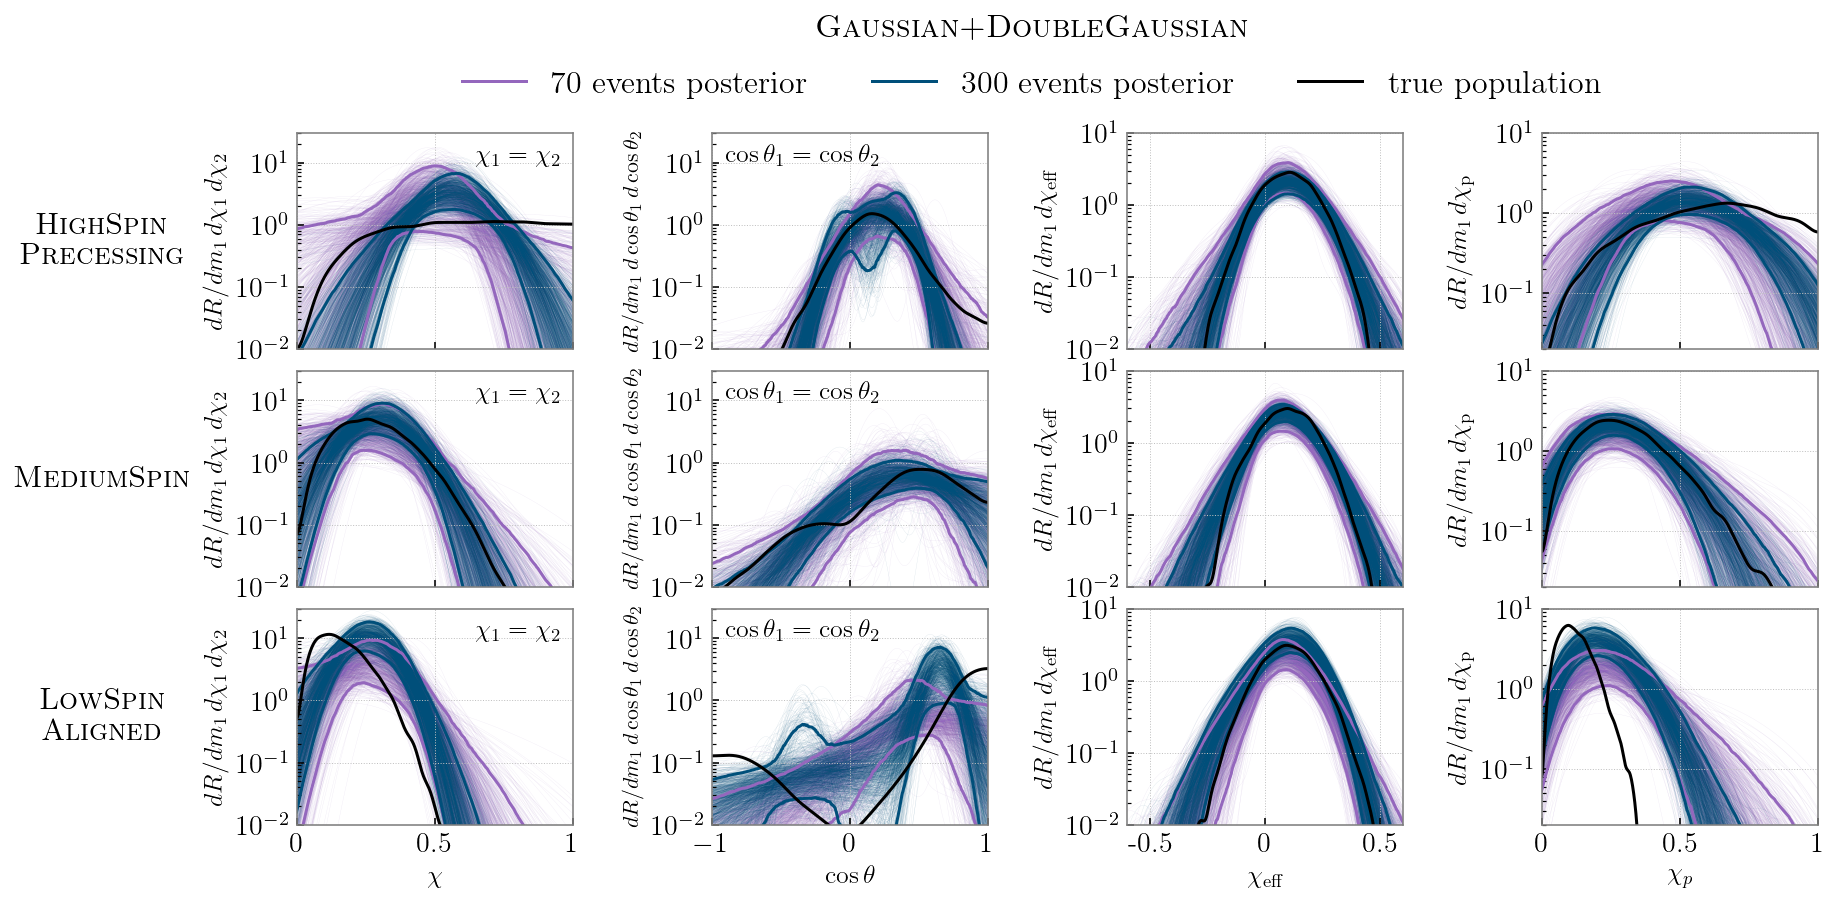

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15/1.1, 7/1.1))

for ax in axes: 
    for a in ax: 
        a.set_rasterization_zorder(2)
        a.set_zorder(3) 

for i,pop_key in enumerate(kde_dict):
    for nevent in nevents: 
        nevent_key = nevent+' events'
        
        if nevent=='070':
            rate_scaling = 1
            label = nevent_key[1:]+' posterior'
        else:
            rate_scaling = (70./300.)
            label = nevent_key+' posterior'
        
        c = nevents_colors_dict[nevent_key]
        
        ## Plot traces from hyperposteriors + 5% and 95% credible bounds

        # spin magnitude
        p_chi = rate_scaling*traces_dict[pop_key][nevent_key]['R_chi']
        axes[i][0].plot(chi_grid, p_chi.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.05,axis=0), color=c, label=label)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.95,axis=0), color=c)

        # tilt angle
        p_cost = rate_scaling*traces_dict[pop_key][nevent_key]['R_cost']
        axes[i][1].plot(cost_grid, p_cost.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=c)
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=c)
        
        # chi effective
        p_chieff = rate_scaling*traces_dict[pop_key][nevent_key]['R_chieff']
        axes[i][2].plot(chieff_grid, p_chieff.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.05,axis=0), color=c)
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.95,axis=0), color=c)

        # chi p
        p_chip = rate_scaling*traces_dict[pop_key][nevent_key]['R_chip']
        axes[i][3].plot(chip_grid, p_chip.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.05,axis=0), color=c)
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.95,axis=0), color=c)

        
    ## Plot injected dists 
    
    # spin magnitude
    axes[i][0].plot(chi_grid, injected_rate_dict[pop_key]*kde_dict[pop_key]['chi']**2, color='k', label='true population')
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(1e-2,3e1)
    axes[i][0].set_yscale('log')
    
    # tilt angle
    axes[i][1].plot(cost_grid, injected_rate_dict[pop_key]*kde_dict[pop_key]['cost']**2, color='k')
    axes[i][1].set_xlim(-1,1)
    axes[i][1].set_ylim(1e-2,3e1)
    axes[i][1].set_yscale('log')
    
    # chi effective
    axes[i][2].plot(chieff_grid, injected_rate_dict[pop_key]*kde_dict[pop_key]['chieff'], color='k')
    axes[i][2].set_xlim(-0.6,0.6)
    axes[i][2].set_ylim(1e-2,1e1)
    axes[i][2].set_yscale('log')
    
    # chi p
    axes[i][3].plot(chip_grid, injected_rate_dict[pop_key]*kde_dict[pop_key]['chip'], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(2e-2,1e1)
    axes[i][3].set_yscale('log')
    
    
    # y-axis labels
    axes[i][0].set_ylabel(r'$dR/dm_1\,d\chi_1\,d\chi_2$', **label_kws)
    axes[i][1].set_ylabel(r'$dR/dm_1\,d\cos\theta_1\,d\cos\theta_2$', fontsize=11, zorder=5)
    axes[i][2].set_ylabel(r'$dR/dm_1\,d\chi_\mathrm{eff}$', **label_kws)
    axes[i][3].set_ylabel(r'$dR/dm_1\,d\chi_\mathrm{p}$', **label_kws)  
    
    # set pop label
    axes[i][0].text(-0.7, 0.5, labels_dict[pop_key], fontsize=15, 
                    horizontalalignment='center', verticalalignment='center', transform=axes[i][0].transAxes)
    
    axes[i][0].text(0.8, 0.9, r"$\chi_1 = \chi_2$", fontsize=13, 
                    horizontalalignment='center', verticalalignment='center', transform=axes[i][0].transAxes)
    
    axes[i][1].text(0.05, 0.9, r"$\cos\theta_1 = \cos\theta_2$", fontsize=13, 
                    horizontalalignment='left', verticalalignment='center', transform=axes[i][1].transAxes)
    
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])

# x-axis labels
axes[2][0].set_xlabel(r'$\chi$', **label_kws)
axes[2][1].set_xlabel(r'$\cos\theta$', **label_kws)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', **label_kws)
axes[2][3].set_xlabel(r'$\chi_p$', **label_kws)  

# Add legend
axes[0][0].legend(bbox_to_anchor=(0.55, 1.1, 1., .102), loc='lower left',ncol=3, borderaxespad=0., fontsize=16)
for ax in axes: 
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        
plt.subplots_adjust(hspace=0.1, wspace=0.5)

plt.suptitle(r'$\mathrm{\textsc{Gaussian+DoubleGaussian}}$', fontsize=16, y=1.01)

for ax in axes:
    for a in ax:
        a.spines['bottom'].set_color('gray')
        a.spines['top'].set_color('gray') 
        a.spines['right'].set_color('gray')
        a.spines['left'].set_color('gray')
        
axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
axes[2][2].set_xticks([-0.5, int(0), 0.5])
axes[2][2].set_xticklabels([-0.5, int(0), 0.5])
axes[2][3].set_xticklabels([int(0), 0.5, int(1)])

plt.tight_layout()
plt.savefig('figure_14.pdf',bbox_inches='tight')
plt.show()